In [1]:
import glob
import sys
sys.path.append('../../segmentations_infrastructure/')
sys.path.append('../scripts/')
from helpers_various import time_str_to_time_s
from DroneVideos import DroneVideos



import os

from Segmentations import Segmentations
from utils_io import convert_to_dict

import matplotlib.pyplot as plt

from utils_draw import plot_presence
from utils_cleaning import remove_nonsegmented_frames, filter_seg_dict
from utils_networks import *
from utils_attention import compute_angles_to_whale_target

import seaborn as sb
import pickle as pk
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
drone_data_dir = "../data/drones/"

baby_epoch_s = time_str_to_time_s('2023-07-08 11:45:45 -0400')

drone_data_hdf5_filepaths = {
  'CETI': os.path.join(drone_data_dir, 'CETI-DJI_MAVIC3-1_metadata.hdf5'),
  'DSWP': os.path.join(drone_data_dir, 'DSWP-DJI_MAVIC3-2_metadata.hdf5'),
}

# load drone data containing frame times
drone_videos = DroneVideos(
    drone_data_hdf5_filepaths=drone_data_hdf5_filepaths,
    video_dirs=None,
    custom_epoch_time_s=baby_epoch_s
)

DroneVideos initializing empty video readers
DroneVideos loading drone data series
  See 42 entries of video data for drone [CETI]


  See 28 entries of video data for drone [DSWP]


In [3]:
## Last update 30-09-2024

segs_raw = {}

segmentation_list = sorted(glob.glob('../data/last/*hdf5'))

for file_name in segmentation_list:
    vid_number = file_name.split("/")[-1].split("_")[0]
    # Open the segmentations data.
    segmentations = Segmentations(h5_filepath=file_name, video_filepaths=None)
    
    # load frame times from drone data
    timestamps_s = drone_videos.get_frame_timestamps_s(video_key=vid_number, use_custom_epoch=False) # standard posix epoch time
    timestamps_s_babyTime = drone_videos.get_frame_timestamps_s(video_key=vid_number, use_custom_epoch=True) # baby time!
    timestamps_str = drone_videos.get_frame_timestamps_str(video_key=vid_number)

    frame_times = [timestamps_s, timestamps_s_babyTime, timestamps_str]


    #extract the dict from hdf5 file
    seg_raw = convert_to_dict(segmentations, frame_times=frame_times, with_masks=False)

    segs_raw[vid_number] = seg_raw
    print(f"Loaded {vid_number}")
    

Loaded 1688827433752
Loaded 1688827660979
Loaded 1688827887072
There should be only one segmentation frequency. segmentation_frequency is [72, 1]
Loaded 1688828965144
Loaded 1688829151574
Loaded 1688829193016
Loaded 1688830733272
Loaded 1688830960531
There should be only one segmentation frequency. segmentation_frequency is [40, 20]
Loaded 1688831187858
There should be only one segmentation frequency. segmentation_frequency is [40, 20]
Loaded 1688831228731
There should be only one segmentation frequency. segmentation_frequency is [40, 20]
Loaded 1688831374924
There should be only one segmentation frequency. segmentation_frequency is [40, 20]
Loaded 1688831602631
Loaded 1688831830406
Loaded 1688832540499
Loaded 1688832767759
There should be only one segmentation frequency. segmentation_frequency is [40, 80]
Loaded 1688832995052
Loaded 1688841618482


## Clean

- set calf id
- remove non segmented frames
- remove whales that appear for few frames


### Calf ids

In [7]:
calf_ids = {}

calf_ids['1688827433752'] = None
calf_ids['1688827660979'] = None
calf_ids['1688827887072'] = None

calf_ids['1688828965144'] = None
calf_ids['1688829151574'] = None
calf_ids['1688829190202'] = None

calf_ids['1688829193016'] = None
calf_ids['1688830733272'] = None
calf_ids['1688830733988'] = None

calf_ids['1688830960531'] = None
calf_ids['1688830961248'] = None
calf_ids['1688831187858'] = None

calf_ids['1688831228731'] = 13
calf_ids['1688831374924'] = 9
calf_ids['1688831602631'] = 4

calf_ids['1688831830406'] = 10
calf_ids['1688832540499'] = 11
calf_ids['1688832767759'] = 6

calf_ids['1688832995052'] = 7
calf_ids['1688841618482'] = 8

In [8]:
appearance_thresholds = {}

appearance_thresholds['1688827433752'] = 150
appearance_thresholds['1688827660979'] = 150
appearance_thresholds['1688827887072'] = 150

appearance_thresholds['1688828965144'] = 150
appearance_thresholds['1688829151574'] = 150
appearance_thresholds['1688829190202'] = 150

appearance_thresholds['1688829193016'] = 150
appearance_thresholds['1688830733272'] = 150
appearance_thresholds['1688830733988'] = 150

appearance_thresholds['1688830960531'] = 150
appearance_thresholds['1688830961248'] = 150
appearance_thresholds['1688831187858'] = 5

threshold_part2 = 40

appearance_thresholds['1688831228731'] = threshold_part2 #30
appearance_thresholds['1688831374924'] = threshold_part2 #40
appearance_thresholds['1688831602631'] = threshold_part2 #70

appearance_thresholds['1688831830406'] = threshold_part2 #40
appearance_thresholds['1688832540499'] = threshold_part2 #60
appearance_thresholds['1688832767759'] = threshold_part2 #60

appearance_thresholds['1688832995052'] = threshold_part2 #60
appearance_thresholds['1688841618482'] = 150

In [7]:
#generate clean segs
segs = {}

vid_numbers = list(segs_raw.keys())

for vid_number in vid_numbers:
    seg = segs_raw[vid_number]
    
    #set calf id
    if calf_ids[vid_number] is not None:
        seg['ids'][calf_ids[vid_number]] = 'Calf'
        
    #Remove non segmented frames
    seg = remove_nonsegmented_frames(seg)
    
    #remove whales that appear for less than thr frames
    seg = filter_seg_dict(seg, appearance_threshold=appearance_thresholds[vid_number])
    
    segs[vid_number] = seg
    
    #Calcuate indeces of whales touching calf
    adj_box_overlap = build_adjacency(seg, box_overlap_binary)
    
    # set diagonals to 0 again
    for i in range(adj_box_overlap.shape[0]):
        np.fill_diagonal(adj_box_overlap[i, :, :], 0)
    
    segs[vid_number]['adj_box_overlap'] = adj_box_overlap
    print(vid_number)
    print(seg['ids'])


  0%|          | 0/6809 [00:00<?, ?it/s]

100%|██████████| 6809/6809 [00:29<00:00, 233.26it/s] 


1688827433752
['Fruit Salad', 'Lady Oracle', 'Accra', 'Soursop', 'Atwood', 'Ariel', 'Snow', 'Aurora', 'Rounder', 'YOY']


100%|██████████| 5627/5627 [00:28<00:00, 198.91it/s]


1688827660979
['Lady Oracle', 'Accra', 'Atwood', 'Fruit Salad', 'Aurora', 'Ariel', 'Soursop', 'Rounder', 'Snow']


100%|██████████| 1760/1760 [00:07<00:00, 246.57it/s]


1688827887072
['Ariel', 'Soursop', 'Rounder', 'Lady Oracle', 'Fruit Salad', 'Snow', 'Atwood', 'Aurora', 'Accra', 'YOY']


100%|██████████| 6050/6050 [00:33<00:00, 180.45it/s]


1688828965144
['Fruit Salad', 'Soursop', 'Lady Oracle', 'SNOW(6196)', 'Rounder', 'Atwood', 'Accra', 'YOY', 'Allan', 'Ariel', 'Atwood', 'Aurora']


100%|██████████| 1202/1202 [00:08<00:00, 141.31it/s]


1688829151574
['Soursop', 'Fruit Salad', 'Rounder', 'Lady Oracle', 'Aurora', 'Ariel', 'Allan', 'Accra', 'Atwood', 'YOY', 'Snow']


100%|██████████| 4702/4702 [00:25<00:00, 181.25it/s]


1688829193016
['Fruit Salad', 'Soursop', 'Atwood', 'Lady Oracle', 'Accra', 'Rounder', 'Snow', '01-07', 'Allan', 'Aurora', 'Ariel', 'YOY']


100%|██████████| 6811/6811 [00:30<00:00, 220.88it/s]


1688830733272
['YOY', 'Accra', 'Ariel', 'Lady Oracle', 'Allan', 'Rounder', 'Aurora', 'Snow', 'Fruit Salad', 'Soursop', 'Atwood']


100%|██████████| 6813/6813 [00:31<00:00, 219.05it/s]


1688830960531
['Soursop', 'Rounder', 'Fruit Salad', 'Accra', 'Allan', 'Lady Oracle', 'Lady Oracle', 'Snow', 'Aurora', 'Whale 11', 'Aurora', 'Soursop', 'Fruit Salad', 'Ariel', 'YOY', 'Atwood']


100%|██████████| 32/32 [00:00<00:00, 531.37it/s]


1688831187858
['Whale 0', '21-01', 'Rounder', 'Lady Oracle', 'Whale 7', 'Whale 8', 'Accra']


100%|██████████| 206/206 [00:00<00:00, 515.15it/s]


1688831228731
['Rounder', 'Whale 5', 'Whale 10', 'Whale 12', 'Calf', 'Whale 18', 'Whale 20', 'Whale 30', 'Whale 31', 'Whale 53']


100%|██████████| 179/179 [00:00<00:00, 267.22it/s]


1688831374924
['Snow', 'Whale 1', 'Rounder', 'Soursop', 'Accra', 'Calf', 'YOY', 'Fruit Salad', 'Lady Oracle', 'Aurora', 'Fruit Salad', 'Aurora', 'Atwood']


100%|██████████| 341/341 [00:01<00:00, 171.44it/s]


1688831602631
['00-04', 'Allan', 'Rounder', 'Calf', '28-06', 'Whale 7', 'Whale 12', 'Whale 17', 'Whale 19', 'Whale 22', 'Allan', 'Whale 29', 'Whale 33', 'Whale 34', 'Whale 35', '36-02', '39-03', '42-08', '46-07', 'Whale 49']


100%|██████████| 182/182 [00:00<00:00, 229.48it/s]


1688831830406
['Atwood', '00-04', '18-05', '43-06', 'Snow', 'Calf', 'Whale 11', 'Whale 16', 'Whale 21', 'Rounder', 'Whale 32', 'Whale 33']


100%|██████████| 154/154 [00:00<00:00, 154.19it/s]


1688832540499
['Fruit Salad', 'Allan', 'Soursop', 'Accra', 'Aurora', 'Rounder', 'Calf', 'Snow', 'YOY', 'Lady Oracle', '20-04', 'Ariel']


100%|██████████| 171/171 [00:01<00:00, 149.08it/s]


1688832767759
['Lady Oracle', 'Fruit Salad', 'Soursop', 'Ariel', 'Calf', 'Atwood', 'Accra', 'Whale 12', 'YOY', 'Whale 14', 'Rounder', 'Whale 20', 'Whale 22', 'Accra', 'Snow', 'Atwood']


100%|██████████| 170/170 [00:01<00:00, 120.46it/s]


1688832995052
['Whale 0', 'Lady Oracle', 'Snow', 'Fruit Salad', 'Atwood', 'Aurora', 'YOY', 'Calf', 'Accra', 'Rounder', 'Allan', 'Soursop', 'Ariel', 'Whale 14']


100%|██████████| 4172/4172 [00:11<00:00, 353.60it/s]

1688841618482
['Atwood', 'Soursop', 'Ariel', 'Rounder', 'Accra', 'Aurora', 'Snow', 'Calf']


In [11]:
segs['1688830733272']['centroids']

array([[[          nan,           nan],
        [1217.74365482,  782.66354006],
        [1163.1655421 ,  984.31278307],
        ...,
        [1476.69079979,  714.2843701 ],
        [          nan,           nan],
        [          nan,           nan]],

       [[          nan,           nan],
        [1218.58659218,  782.71716508],
        [1162.47788346,  984.47068058],
        ...,
        [1476.6252977 ,  714.38687483],
        [          nan,           nan],
        [          nan,           nan]],

       [[          nan,           nan],
        [1220.28537481,  782.62767336],
        [1162.54547103,  984.70341826],
        ...,
        [1476.29364252,  714.30588848],
        [          nan,           nan],
        [          nan,           nan]],

       ...,

       [[          nan,           nan],
        [          nan,           nan],
        [          nan,           nan],
        ...,
        [ 958.37427141,  605.16714555],
        [          nan,           nan],
        [

In [17]:
with open ('../data/last/segmentations_clean.pkl', 'wb') as f:
    pk.dump(segs, f)

In [9]:
with open('../data/last/segmentations_clean.pkl', 'rb') as f:
    segs = pk.load(f)

## Compute angles

In [13]:
from collections import OrderedDict
all_angles = OrderedDict()
for vid_number in vid_numbers:
    all_angles[vid_number] = {}
    for whale_id in segs[vid_number]['ids']:
        angles_to_target = compute_angles_to_whale_target(segs[vid_number], whale_id)
        all_angles[vid_number][whale_id] = angles_to_target

In [22]:
all_angles['1688830733272']['Snow']

array([[       nan, 0.01045077, 0.47802575, ...,        nan,        nan,
               nan],
       [       nan, 0.01082583, 0.47701532, ...,        nan,        nan,
               nan],
       [       nan, 0.01607337, 0.47270705, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [19]:
# Define the file path
file_path = "../results/all_angles.pkl"

# Dump the all_angles variable as a pickle file
with open(file_path, "wb") as file:
    pk.dump(all_angles, file)

In [4]:
file_path = "../results/all_angles.pkl"

with open(file_path, "rb") as file:
    all_angles = pk.load(file)

## Plot single video

In [5]:
def plot_angles_target(angles_taget_sightline, seg_filtered, vid_num, target_name='calf'):
    
    sb.set_palette("tab20")

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(7, 2), sharey=False)


    n_frames, num_whales = seg_filtered["orientations_rad"].shape

    ax.plot(np.cos(angles_taget_sightline), label=seg_filtered["ids"])

    angle_target_sightline_avg_over_time = np.nanmean(np.cos(angles_taget_sightline), axis=0) 
    angle_target_sightline__std_over_time = np.nanstd(np.cos(angles_taget_sightline), axis=0) 

    #ax.set_ylim([-0.05, 1.05])
    #ax.set_xlim(xmin=-50)
    #ax.set_yticks([0, 0.5, 1])

    #ax.set_ylabel("Avg distance to other calf")
    #ax.set_xlabel("Time frame")

    ax.legend(loc="center left", bbox_to_anchor=(2.3, 0.5))


    colors = sb.color_palette("tab20", n_colors=num_whales)

    ax2.bar(x=range(num_whales), height=angle_target_sightline_avg_over_time, color=colors)

    ax2.errorbar(range(num_whales), angle_target_sightline_avg_over_time, yerr=angle_target_sightline__std_over_time, fmt="o", color="k")

    ax2.set_xlabel("Whale index")
    ax2.set_xticks(range(num_whales))
    ax2.set_xticklabels(seg_filtered["ids"])
    plt.xticks(rotation=90)


    ax.set_title("angle cosine (1=aligned)")
    ax2.set_title("averaged over time")
    plt.subplots_adjust(top=0.8)
    plt.suptitle(f"Vid n:{vid_num} - {target_name}")

    sb.despine()

    #fig_name = f"distance_to_others_frame_{frame}_dist_treshold_{dist_max}"
    #plt.savefig(f"{results_vid_dir}{fig_name}.png", dpi=250, bbox_inches="tight", facecolor="w")

    #plt.show()
    plt.draw()
    
    return plt.gcf()
    

/tmp/ipykernel_2644776/1256425344.py:12: RuntimeWarning: Mean of empty slice
  angle_target_sightline_avg_over_time = np.nanmean(np.cos(angles_taget_sightline), axis=0)
/home/poetz/anaconda3/envs/ceti/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


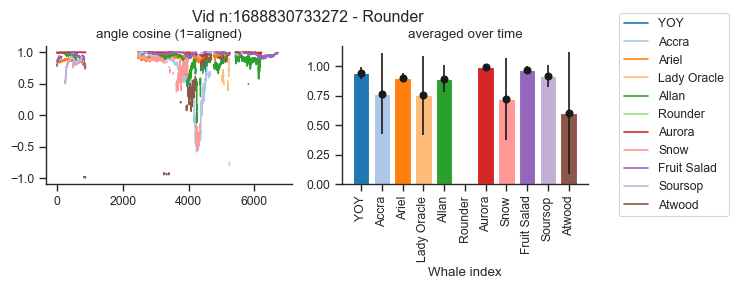

In [10]:
video = 1688830733272
whale = 'Rounder'
plot_angles_target(all_angles[str(video)][whale], segs[str(video)], video, whale);

/tmp/ipykernel_2644776/1256425344.py:12: RuntimeWarning: Mean of empty slice
  angle_target_sightline_avg_over_time = np.nanmean(np.cos(angles_taget_sightline), axis=0)
/home/poetz/anaconda3/envs/ceti/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


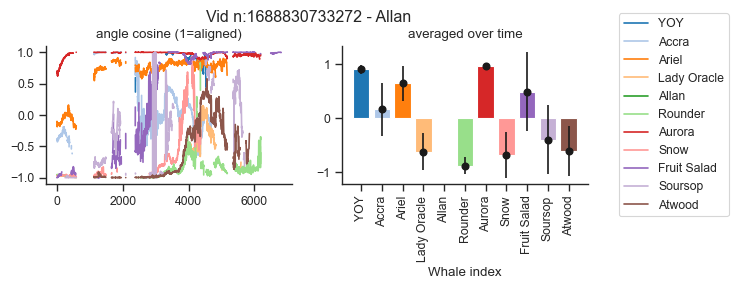

In [11]:
video = 1688830733272
whale = 'Allan'
plot_angles_target(all_angles[str(video)][whale], segs[str(video)], video, whale);

/tmp/ipykernel_2644776/1256425344.py:12: RuntimeWarning: Mean of empty slice
  angle_target_sightline_avg_over_time = np.nanmean(np.cos(angles_taget_sightline), axis=0)
/home/poetz/anaconda3/envs/ceti/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


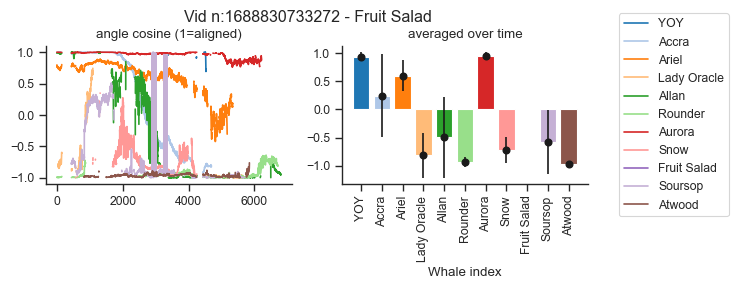

In [12]:
video = 1688830733272
whale = 'Fruit Salad'
plot_angles_target(all_angles[str(video)][whale], segs[str(video)], video, whale);